# Botón Para Esconder Código

In [42]:
#Sacado de https://mljar.com/blog/jupyter-notebook-hide-code/
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Aprete aqui para visualizar/esconder bloques de codigo."></form>''')

## Libraries y Display

In [131]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import statistics
from sklearn.svm import SVC

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Parte I: Análisis de la base de hogares y cálculo de pobreza

1)  Abrimos la base de datos de la EPH y nos quedamos con los observaciones de GBA.

In [44]:
#Abrimos la base
hogar = pd.read_excel('./EPH_usu_1er_Trim_2022_xlsx/usu_hogar_T122.xlsx')

#Eliminamos todos los aglomerados que no correspondan a CABA (cód 32) o GBA (cód 33)
hogar_cortado = hogar.query("AGLOMERADO in (32, 33)") # la manera mas rapida y facil de hacerlo


2) Unimos encuesta individual y encuesta hogar (en base a CODUDU y NRO HOGAR)

In [45]:
#Importamos tabla individual 
#Abrimos la base
individual = pd.read_excel('./EPH_usu_1er_Trim_2022_xlsx/usu_individual_T122.xlsx')

#Eliminamos todos los aglomerados que no correspondan a CABA (cód 32) o GBA (cód 33)
individual_cortado = individual.query("AGLOMERADO in (32, 33)") # la manera mas rapida y facil de hacerlo


In [46]:
# Definimos las intersección entre las dos bases como una lista
columnas_duplicadas = set(individual_cortado.columns).intersection(set(hogar_cortado.columns))
# Removemos CODUSU y NRO_HOGAR de la lista ya que queremos usarlas para la intersección (y las columnas sobre las que se une
# no generan duplicados)
columnas_duplicadas.remove("CODUSU")
columnas_duplicadas.remove("NRO_HOGAR")

# Hacemos el merge habiendo dropeado las columnas repetidas
eph = pd.merge(
    individual_cortado.drop(columnas_duplicadas, axis=1), 
    hogar_cortado,
    on= ['NRO_HOGAR', 'CODUSU']
)

3) 
- A continuación, listamos las funciones y procediientos que usamos para limpiar la base:

- Para eliminar aquellas observaciones relacionadas a ingreso que sea negativo, utilizaremos el metodo .loc, combinando con el prefijo ~ para expresar que queremos localizar aquellas que no sean negativas en algun punto.
-  Eliminamos duplicados con .drop_duplicates
- Con .isnull, .dropna y .shape eliminamos aquellas columnas que tengan mas de un porcentaje de NAs.
- Armando un interquantile range score eliminamos outliers que en cierto rango.
- Para Boxplots, seaborn y matplotlib.
- Con .dtypes nos fijamos el tipo de las variables restantes.
- Categoricas reemplazamos NaN por metodos .fillna, .isnull, .add_categories.
- Continuas relacionadas a ingreso con NAs, asumimos que la no respuesta es un 0 en caso de que no venga ya asi la base.
- Eliminaremos outliers utilizando interquantile range scores para detectarlos y eliminarlos.


In [47]:
#Eliminamos aquellas que tengan ingreso o edad negativa
eph = eph.loc[~(
(eph['CH06']<0) | 
(eph['PP08D1']<0) | 
(eph['PP08D4']<0) |
(eph['PP08F1']<0) |
(eph['PP08F2']<0) |
(eph['PP08J1']<0) |
(eph['PP08J2']<0) |
(eph['PP08J3']<0) |
(eph['ITF']<0) |
(eph['IPCF']<0) )]

In [48]:
#Chequeamos si hay duplicados y los dropeamos
eph = eph.drop_duplicates()
#no hay duplicados, cool!

In [49]:
#Cheque columnas con muchos NAs, si tiene mas de 70% los vamos a  borrar 
#Notese quiebre de NAs en 96% y 81%, no es tan arbitrario el 70%
percent_missing = eph.isnull().sum() * 100 / len(eph)
missing_value_eph = pd.DataFrame({'Columna': eph.columns,
                                 'Porcentaje de NAs': percent_missing})
missing_value_eph.sort_values('Porcentaje de NAs', inplace=True,ascending=False)


In [50]:
#Borramos mas de 80%
perc = 70.0
min_count =  int(((100-perc)/100)*eph.shape[0] + 1)
eph = eph.dropna( axis=1, 
                thresh=min_count)
#chequeamos haber borrado lo que queriamos
percent_missing = eph.isnull().sum() * 100 / len(eph)
missing_value_eph = pd.DataFrame({'Columna': eph.columns,
                                 'Porcentaje de NAs': percent_missing})
missing_value_eph.sort_values('Porcentaje de NAs', inplace=True,ascending=False)


In [51]:
#Outliers: Nos quedaremos con los valores de ingreso entre los cuantiles
#siguiendo el metodo de interquantile range score propuesto en https://www.pluralsight.com/guides/cleaning-up-data-from-outliers

variables_para_outliers=[
'PP08D1','PP08D4','PP08F1','PP08F2','PP08J1','PP08J2','PP08J3','ITF','IPCF',
'P21', 'TOT_P12', 'P47T'
]


<AxesSubplot:xlabel='variable', ylabel='value'>

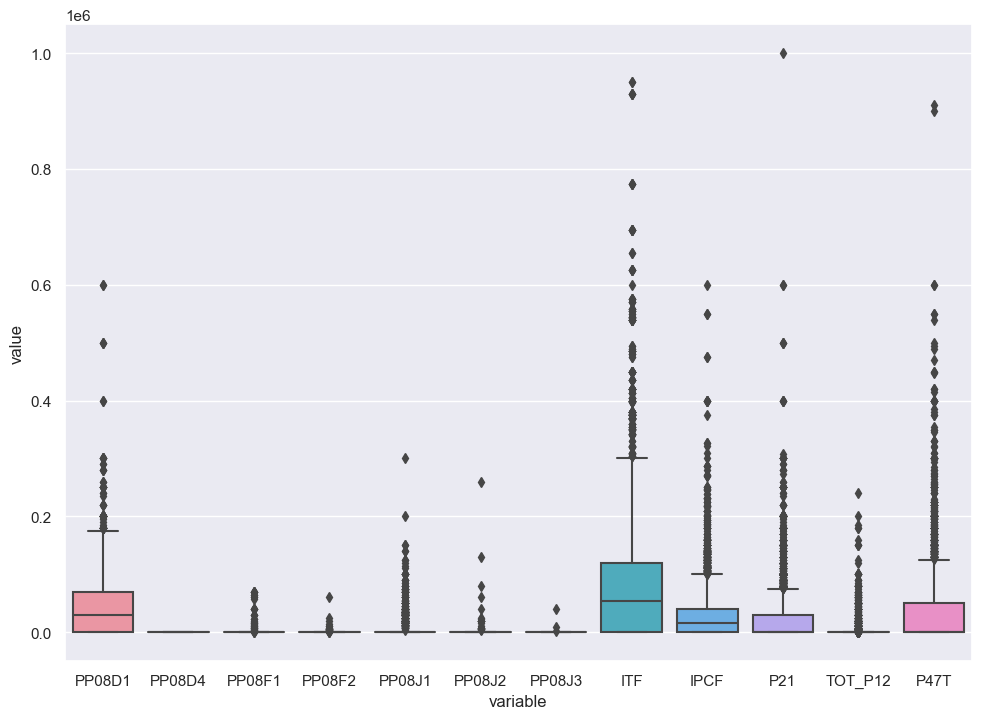

In [52]:
#Boxplots de variables que chequeamos outliers
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="variable", y="value", data=pd.melt(eph[variables_para_outliers]))



In [53]:
#Generamos Interquantile Ranges, con eso sacamos los que queden afuera
#Asimetrico por ser ingreso una variable con lower bound pero no upper bound
Qlow = eph[variables_para_outliers].quantile(0)
Qhigh = eph[variables_para_outliers].quantile(0.90)
IQR = Qhigh - Qlow
print(IQR)
eph_inc = eph[variables_para_outliers]
eph_out = eph_inc[~((eph_inc < (Qlow - 1.5 * IQR)) |(eph_inc > (Qhigh + 1.5 * IQR))).any(axis=1)]
indexes = eph_out.index.values.tolist() 
eph=eph.loc[indexes]
print('No es sorpresa que sean 0 las que en graficos no tienen outliers faciles de observar a ojo. Notar que todas con outliers para arriba, no borramos los 0, mas en variables donde sean NO RESPONDE.')

PP08D1     110000.0
PP08D4          0.0
PP08F1          0.0
PP08F2          0.0
PP08J1      13000.0
PP08J2          0.0
PP08J3          0.0
ITF        203000.0
IPCF        70800.0
P21         80009.0
TOT_P12         9.0
P47T        95709.0
dtype: float64
No es sorpresa que sean 0 las que en graficos no tienen outliers faciles de observar a ojo. Notar que todas con outliers para arriba, no borramos los 0, mas en variables donde sean NO RESPONDE.


In [54]:
eph['ITF'].min()

0

In [55]:
#Chequeamos tipo de las variable restantes
eph.info(verbose=True)
print("Son todas object, int64 o float64, visto en una tabla:")
eph.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5459 entries, 0 to 6705
Data columns (total 198 columns):
 #    Column      Dtype  
---   ------      -----  
 0    CODUSU      object 
 1    NRO_HOGAR   int64  
 2    COMPONENTE  int64  
 3    H15         int64  
 4    CH03        int64  
 5    CH04        int64  
 6    CH05        object 
 7    CH06        int64  
 8    CH07        int64  
 9    CH08        int64  
 10   CH09        int64  
 11   CH10        int64  
 12   CH11        int64  
 13   CH12        int64  
 14   CH13        int64  
 15   CH14        float64
 16   CH15        int64  
 17   CH16        int64  
 18   NIVEL_ED    int64  
 19   ESTADO      int64  
 20   CAT_OCUP    int64  
 21   CAT_INAC    int64  
 22   PP02C1      int64  
 23   PP02C2      int64  
 24   PP02C3      int64  
 25   PP02C4      int64  
 26   PP02C5      int64  
 27   PP02C6      int64  
 28   PP02C7      int64  
 29   PP02C8      int64  
 30   PP02E       int64  
 31   PP02H       int64  
 32   PP

int64      126
float64     69
object       3
dtype: int64

In [56]:
#Definimos que variables no son categoricas
categoricas = ['CH03', 'CH04', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH16', 'NIVEL_ED',
               'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'PP02C1', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C5', 'PP02C6', 'PP02C7', 
               'PP02C8', 'PP02E', 'PP02H', 'PP02I', 'PP03C', 'PP03G', 'PP03H', 'PP03I', 'PP03J', 'INTENSI', 'PP04A', 
               'PP04B1', 'PP04B3_MES', 'PP04B3_ANO', 'PP04B3_DIA', 'PP04C', 'PP04C99', 'PP04G', 'PP05B2_MES', 'PP05B2_ANO',
               'PP05B2_DIA', 'PP05C_1', 'PP05C_2', 'PP05C_3', 'PP05E', 'PP05F', 'PP05H', 'PP06A', 'PP06E', 'PP06H', 'PP07A',
               'PP07C', 'PP07D', 'PP07E', 'PP07F1', 'PP07F2', 'PP07F3', 'PP07F4', 'PP07F5', 'PP07G1', 'PP07G2', 'PP07G3', 
               'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K', 'PP09A', 'PP09B', 'PP09C', 'IV1', 'IV2', 'IV3', 
               'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11', 'IV12_1', 'IV12_2', 'IV12_3', 'II1', 'II2', 'II3', 
               'II3_1', 'II4_1', 'II4_2', 'II4_3', 'II5', 'II5_1', 'II6', 'II6_1', 'II7', 'II8', 'II9', 'V1', 'V2', 'V21', 
               'V22', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17',
               'V18', 'V19_A', 'V19_B', 'IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2',
               'VII2_3', 'VII2_4']
#Me fijo cuales fueron borradas mas arriba por tener muchos NAs
no_borradas = pd.Index(categoricas).difference(eph.columns).tolist()
#las saco
categoricas = pd.Index(categoricas).difference(no_borradas).tolist()

In [57]:
#Las convertimos a categoricas
eph_d=eph.copy()
eph_d[categoricas] = eph_d[categoricas].astype('category')


In [58]:
#Reemplazamos NAs de categoricas por -1
for col in categoricas:
    eph_d[col]=eph_d[col].cat.add_categories(['-1'])
    eph_d[col]=eph_d[col].fillna('-1')


In [59]:
columnas_llenar_con_ceros = eph.columns[eph.isnull().any()]
eph[columnas_llenar_con_ceros]=eph[columnas_llenar_con_ceros].fillna(0)

PARA QUE ES eph_d ??????

4) Creamos 2 nuevas variables:
 _hab= cociente entre miembros del hogar y cantidad de habitaciones
 _niños= proporción de niños menores a 10 años en el hogar

In [60]:
#Definimos hab
eph["hab"]=eph["IX_TOT"]/eph["IV2"]

#Definimos niños
eph["niños"]=eph["IX_MEN10"]/eph["IX_TOT"]

5) Analizamos la correlación entre Nivel educativo (NIVEL_ED), Cantidad de miembros del hogar (IX_TOT) e Ingreso Total Familiar (ITF).

Text(0, 0.5, 'Ingreso total Familiar')

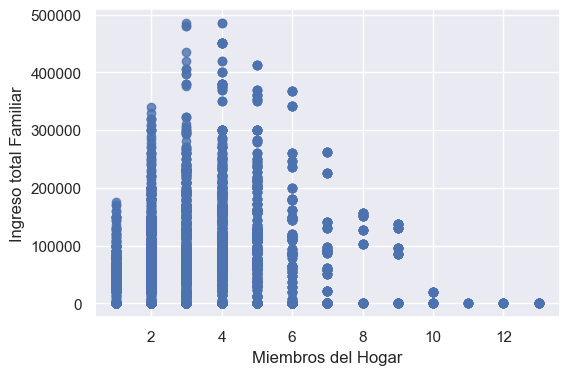

In [61]:
# Gráfico: (IX_TOT;NIVEL_ED)
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=eph.IX_TOT, y=eph.ITF, alpha= 0.8)
ax.set_xlabel('Miembros del Hogar')
ax.set_ylabel('Ingreso total Familiar')

<AxesSubplot:>

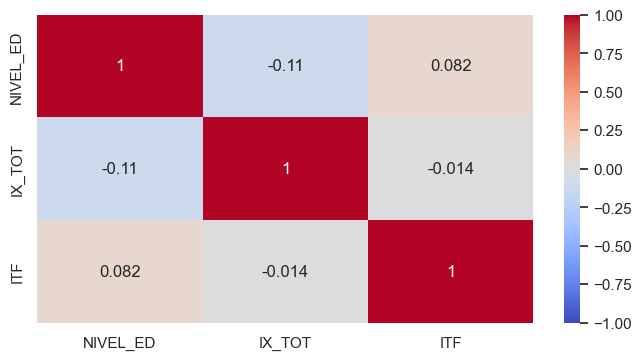

In [62]:
import seaborn as sns

df_corr=eph[["NIVEL_ED", "IX_TOT", "ITF"]]
sns.set(rc = {'figure.figsize':(8,4)})
sns.heatmap(df_corr.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

En el primer gráfico observamos que las familias de mayores ingresos están compuestas por 3 o 4 miembros. A partir de esa cantidad de miembros el ingreso de la familia disminuye a mayor cantidad de miembros, haciendo que en la matriz de correlación observemos una correlación negativa entre ingreso familiar y cantidad de miembros. 

6) 
-Agregamos la columna adulto_equiv y adulto_equiv_hogar

In [63]:
df_equiv = pd.read_excel('tabla_adulto_equiv.xlsx')

df_equiv.loc[1,"Edad"]=1


for i in range(0,18):
    df_equiv.loc[i,"Edad"]= i 

for i in range(18,30): #18-29 años 0.76/1.02
    df_equiv.loc[i]= [i,0.76,1.02] 

for i in range(30,46): #30-45 años 0.77/1
    df_equiv.loc[i]= [i,0.77,1] 

for i in range(46,61): #46-60 años 0.76/1
    df_equiv.loc[i]= [i,0.76,1] 

for i in range(61,76): #61-75 años 0.67/0.83
    df_equiv.loc[i]= [i,0.67,0.83]

for i in range(76,106): #18-29 años 0.63/0.74. La edad max en la EPH es 105 años. 
    df_equiv.loc[i]= [i,0.63,0.74] 

df_equiv = df_equiv.rename(columns={'Edad':'CH06'})


In [64]:
df_eph= eph.merge(df_equiv, on='CH06')

for i in range(len(df_eph)):
    if df_eph.loc[i,"CH04"]==1:
        df_eph.loc[i,"adulto_equiv"]=df_eph.loc[i,"Varones"]
    elif df_eph.loc[i,"CH04"]==2:
        df_eph.loc[i,"adulto_equiv"]=df_eph.loc[i,"Mujeres"]


df_eph.drop (["Varones","Mujeres"] , axis =1 , inplace = True)

In [65]:
df_sum=df_eph.groupby(['CODUSU', 'NRO_HOGAR'])[['adulto_equiv']].agg('sum')
df_sum.reset_index( inplace = True )
df_sum = df_sum.rename(columns={'adulto_equiv':'ad_equiv_hogar'})

df_eph=df_eph.merge(df_sum, on=["CODUSU", "NRO_HOGAR"])
df_eph=df_eph.sort_values(by="CODUSU")

#El data frame relevante ahora es df_eph


-Dividimos la base en respondieron y no respondieron 

In [66]:
#Guardamos las obs que respondieron en el df 'df_respondieron':
df_respondieron = df_eph.drop(df_eph[df_eph['ITF']<=0].index)
df_respondieron.reset_index(inplace=True, drop=True)

##Guardamos las obs que no respondieron en el df 'df_norespondieron':
df_norespondieron= df_eph.drop(df_eph[df_eph['ITF']>0].index) 
df_norespondieron.reset_index( inplace = True )

-Agregamos la variable "ingreso_necesario"

In [67]:
df_respondieron["ingreso_necesario"]=df_respondieron["ad_equiv_hogar"]*(27197.64) #$27197.64 es la CBA


7) Agregamos la variable "pobre"

In [68]:

df_respondieron['Pobre'] = np.where(df_respondieron['ITF'] < df_respondieron['ingreso_necesario'], 1, 0)

8) Calculamos la tasa de hogares pobres para GBA, utilizando el ponderador PONDICH.


In [69]:
#Me quedo solo con GBA
df_respondieron_GBA =df_respondieron[df_respondieron['REGION']==1]

In [70]:
#Creamos base con solo una observacion por hogar
eph_hogares=df_respondieron_GBA.groupby(['CODUSU','NRO_HOGAR']).agg({"Pobre" : "mean","PONDIH" : "sum"})
#Sumamos cuanto hay de cada uno. 
sumas=eph_hogares.groupby("Pobre").PONDIH.sum().to_frame()
eph_porcentajes = sumas.apply(lambda x:
                                                 100 * x / float(x.sum()))
print(eph_porcentajes)


          PONDIH
Pobre           
0.0    65.659653
1.0    34.340347


Notese que el porcentaje de pobres utilizando este metodo solo para REGION del GBA (distinto era si usabamos AGLOMERADO 33, partidos del GBA) es de 34.34%, mas de 4 p.p. por debajo del 39,2% reportado por INDEC considerando a nivel individual. 

## PARTE II

In [132]:

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.svm import SVC

1) Definimos la función evalua_metodo. Qué toma como inputs las bases de train y test para X e Y y el modelo deseado (LogisticRegression, LinearDiscriminantAnalysis, KNeighborsClassifier,DecisionTreeClassifier,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,svm) con su hiperparámetro. Y devuelve una colección con las métricas correspondientes a cada modelo, entre las que se encuentran:  ECM, Auc, Presición,  Verdaderos Positivos, Verdaderos Negativos, Falsos Positivos y Falsos Negativos. 

In [135]:
def evalua_metodo(X_train, X_test, y_train, y_test, model, hiperparam, lasso=1, hiperparam_2=3):
    '''    
    Toma como parametros las bases de train y test y el modelo deseado de clasificación (LogisticRegression, LinearDiscriminantAnalysis,
    KNeighborsClassifier,DecisionTreeClassifier,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,svm) y el valor de los hiperparámetros de cada modelo.  
    Devuelve las métricas: Accuracy, AUC y ECM.
    Para hacer elastic net reducir el valor predeterminado del parámetro lasso, lasso=0 indica Ridge. 
    '''
    if model==DecisionTreeClassifier:
        y = model(max_depth = hiperparam).fit(X_train, y_train)
    elif model== LogisticRegression:
        y = model(C=1/hiperparam, penalty="elasticnet", solver="saga", l1_ratio=lasso, tol=0.01).fit(X_train, y_train).fit(X_train, y_train) # l1_ratio=1 se hace Lasso | l1_ratio=0 se hace Ridge | 0 <l1_ratio< 1 combinación de ambos en elastic net.      
    elif model==BaggingClassifier:
        y=model(n_estimators=hiperparam, max_samples=200, random_state=0).fit(X_train, y_train) #base_estimator=None(hace DecicionTreeClass.); bootstrap=True
    elif model==RandomForestClassifier:
        y=model(n_estimators=hiperparam, max_samples=200, max_features=hiperparam_2, random_state=0).fit(X_train, y_train)
    elif model== AdaBoostClassifier:
        y=model(n_estimators=hiperparam, random_state=0).fit(X_train, y_train)
    elif model==svm:
        y=svm.SVC(C=1/hiperparam).fit(X_train, y_train)
    if model==KNeighborsClassifier:
        y = model(hiperparam).fit(X_train, y_train)
    else:
        y = model().fit(X_train, y_train)

    y_pred = y.predict(X_test)

    matriz_confusion = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, tresholds = roc_curve(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    ecm = mean_squared_error(y_test, y_pred)

    df_metrics = pd.DataFrame({'modelo': [model], 'accuracy': [accuracy], 'auc':[auc], 'ecm':[ecm], 'VP': [matriz_confusion[1,1]], 'FP': [matriz_confusion[0,1]], 'VN':matriz_confusion[0,0], 'FN':matriz_confusion[1,0]})

    return df_metrics

2) Definimos la función cross_validation(model, x, y, hiperparam, hiperparam_2, k_cv, standard=false) que toma como input el modelo desado (LogisticRegression, LinearDiscriminantAnalysis, KNeighborsClassifier,DecisionTreeClassifier,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,svm)las bases X e Y,el valor del hiperparámetro del modelo, el valor del segundo hiperparámetro del modelo y la cantidad de particiones 'k' para hacer CV. Standard=True indica si se quiere estandarizar las variables para hacer CV. La función devuelve la media de los ECM de las k estimaciones realizadas por el método de cross-validation.

In [129]:
def cross_validation(model, x, y, hiperparam ,lasso=1, hiperparam_2=3, k=5, standard=False):
    sc = StandardScaler()
    
    kf = KFold(n_splits=k, shuffle=True)

    ecm = []

    for i, (train_index, test_index) in enumerate(kf.split(x)):   
        x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
            
        if standard==True:
            # Estandarizamos las observaciones de entrenamiento
            x_train = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
            # Estandarizamos las observaciones de test
            x_test = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)

        ecm2 = evalua_metodo(x_train, x_test, y_train, y_test, model, hiperparam, lasso=lasso, hiperparam_2=hiperparam_2)
        ecm3 = ecm2['ecm'][0]
        ecm.append(ecm3)
        
    final_ecm = statistics.mean(ecm)

    return final_ecm

3) Definimos la función evalua_config(model,hiperparam, x, y,k_cv,hiperparam_2, two_hiperparam, standard) que toma cómo inputs un modelo, una collección de valores de hiperparámetros (pueden ser una matriz o lista),las bases X e Y, el k de cross-validation y una colección de valores para un segundo hiperparámetro. two_hiperparam=True indica que se quiere optimar el modelo eligiendo 2 hiperparámetros. Standard=True indica que se estandarizan las varibales al hacer CV. Con esta información la función se encarga de calcular el/los hiperparámetros que minimiza/n el ECM por Cross-validation. Retorna el/los valor/es de hiperparámetro/s óptimo/s. 

In [122]:
def evalua_config (model,hiperparam, x, y, k=5, hiperparam_2=1, two_hiperparam=False, standard=False, lasso=1):
    '''
    Toma cómo input un modelo, una serie de valores de hiperparámetros para ese modelo y el K para CV.
    Devuelve el hiperparámetro que minimiza el ECM por CV. Standard=True indica que se hace CV con variables standarizadas.
    Para Logistic Regression optimiza el lambda y el parámetro de elastic net. 
    '''
    
    ret={}
    lasso=np.arange(0,lasso,0.1).tolist() #lista de parámetros de elastic net
    if model==LogisticRegression:
        for elem in hiperparam:
            for elem_2 in lasso:
                ecm=cross_validation(model,x,y,elem, lasso=elem_2, k=k, standard=standard)
                ret[(elem,elem_2)]= ecm
        
        return min(ret, key=ret.get) 
    
    if two_hiperparam==True:
        for elem in hiperparam:
            for elem_2 in hiperparam_2:
                ecm=cross_validation(model,x,y,elem,hiperparam_2=elem_2,k=k, standard=standard)
                ret[(elem,elem_2)]= ecm
                

        
        return min(ret, key=ret.get)     
    
    elif two_hiperparam==False:
       for elem in hiperparam:     
            ecm=cross_validation(model,x, y,elem,k=k, standard=standard)
            ret[elem]= ecm 
       return min(ret, key=ret.get) #Devuelve el hiperarámetro que minimiza el ecm.

4) Definimos la función evalua_metodos(hiperparam_max, x_train, x_test , y_train, y_test, x, y, k_cv, hiperparam_2) que toma cómo inputs el k de Cross-Validation, el valor máximo a testear del hiperparámetro, las bases de train y test de X e Y, y las bases completas de X e Y. La función se encarga de calcular los modelos: KNN, Regresión logistica, Análisis Lineal de Discriminante, Árbol de Decisión, Ramdom Forest, Boosting, Bagging y SVM. Y devuelve una tabla con las métricas correspondientes a cada modelo, entre las que se encuentran: hiperparámetro elegido por CV, ECM, Auc, Presición,  Verdaderos Positivos, Verdaderos Negativos, Falsos Positivos y Falsos Negativos. 
Con el valor del hiperparm_max lo que hace es generar una lista desde 1 hasta ese valor máximo, avanzando de a 3 unidades (lo establecimos así para reducir tiempo de computo, pero se podría establecer cualquier otro número entero).  

In [126]:
def evalua_multiples_metodos (hiperparm_max, x_train, x_test , y_train, y_test, k=5, hiperparam_2_max=5): 
    


    modelos = [[LogisticRegression,"LogisticRegression"],[KNeighborsClassifier,"KNeighborsClassifier"],[LinearDiscriminantAnalysis,"LinearDiscriminantAnalysis"], [DecisionTreeClassifier,"DecisionTreeClassifier"],[BaggingClassifier,"BaggingClassifier"],[AdaBoostClassifier,"AdaBoostClassifier"],[svm,"svm"],[RandomForestClassifier,"RandomForestClassifier"]]

    hiperparam= np.arange(1,hiperparm_max,1).tolist() #Para reducir el tiempo de computo establecemos que los hiperparámetros a testear son números enteros. 

    matriz = pd.DataFrame(columns=["Modelo", "Hiperparametro 1","Hiperparametro 2","ECM", "AUC",'Accuracy', 'VP', 'VN', 'FP', 'FN'])
    print(matriz)
    for modelo in modelos:
        
        if modelo[0]==RandomForestClassifier:
            hiperparam_2=np.arange(1,hiperparam_2_max,1).tolist()
            hiper_opt = evalua_config(modelo[0],hiperparam, x_train, y_train, k=k, hiperparam_2=hiperparam_2,two_hiperparam=True) 
            print("hola sot hiper opt rf",hiper_opt)
            metricas= evalua_metodo(x_train, x_test , y_train, y_test , modelo[0], hiper_opt[0], hiperparam_2=hiper_opt[1]) 
            results = [modelo[1], hiper_opt[0], hiper_opt[1] ,metricas['ecm'][0], metricas['auc'][0], metricas['accuracy'][0], metricas['VP'][0],metricas['VN'][0], metricas['FP'][0],metricas['FN'][0]]
            matriz.loc[len(matriz)] = results
            print("termine con RF")
        if modelo[0]==LogisticRegression:
            hiper_opt = evalua_config(modelo[0],hiperparam, x_train, y_train,lasso=1,k=k, standard=True ) 
            metricas= evalua_metodo(x_train, x_test , y_train, y_test , modelo[0], hiper_opt[0],lasso=hiper_opt[1]) 
            results = [modelo[1], hiper_opt[0], hiper_opt[1] ,metricas['ecm'][0], metricas['auc'][0], metricas['accuracy'][0], metricas['VP'][0],metricas['VN'][0], metricas['FP'][0],metricas['FN'][0]]
            matriz.loc[len(matriz)] = results
            print("termine con LOGISTIC REG")
        else:
            hiper_opt = evalua_config(modelo[0],hiperparam, x_train, y_train, k=k, standard=True ) 
            metricas= evalua_metodo(x_train, x_test , y_train, y_test , modelo[0], hiper_opt)
            print("HOLAAAA", hiper_opt)
            results = [modelo[1], hiper_opt,"NA", metricas['ecm'][0], metricas['auc'][0], metricas['accuracy'][0], metricas['VP'][0],metricas['VN'][0], metricas['FP'][0],metricas['FN'][0]]
            matriz.loc[len(matriz)] = results
            print("termine con", modelo[1])
    
    return(matriz)

## PARTE III

1) Eliminamos todas variables de ingreso. Especificamos a que tipo de ingreso esta relacionada cada una. Dado que borramos algunas por tener demasiados NAs, borramos obviamente las no previamente decartadas, sacando la diferencia entre las variables definidas y las ya borradas. 

In [ ]:
variables_ingreso = [
    "ITF","DECIFR","IDECIFR","RDECIFR","GDECIFR", "PDECIFR","ADECIFR", #Ingreso total familiar
    "IPCF", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR", "PDECCFR", "ADECCFR", "PONDIH", #Ingreso per capita familiar
    "PP06A", "PP06C", "PP06D", "PP06E", "PP06H", #Ingreso de las ocupaciones principales de independientes
    "PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3",#Ingreso de las ocupaciones principales de asalariados
    "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "PONDIIO", #Ingreso de la ocupacion principal
    "TOT_P12", #Ingreso de otras ocupaciones
    "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", "PDECINDR", "ADECINDR", "PONDII",#Ingreso total individual
    "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M", "T_VI", #Ingresos no laborales
    "adulto_equiv", "ad_equiv_hogar",  "ingreso_necesario"#Equivalentes e ingreso necesario
]
#Me fijo cuales fueron borradas mas arriba por tener muchos NAs
borradas = pd.Index(variables_ingreso).difference(df_norespondieron.columns).tolist()
#las saco
variables_ingreso_no_borradas = pd.Index(variables_ingreso).difference(borradas).tolist()

#Eliminamos
df_respondieron.drop(columns = variables_ingreso_no_borradas)
df_respondieron.drop(columns = ['ingreso_necesario']) #Esta solo en df_respondieron
df_norespondieron.drop(columns = variables_ingreso_no_borradas)

EL BLOQUE ANTERIOR DA UN PRINT LARGUISIMO DE TODA LA BASE NOSE POR QUE!!!!!!

Definimos y'' (variable dependiente) igual a sí es pobre o no. X (matriz de variables independientes) es el resto de variables que quedarin en la base, y agregamos el ventor de constantes. 

In [83]:
#Recordemos que tenemos 2 data base relevantes: df_respondieron y df_norespondieron
#Pasamos a float la variable MAS_500 que es de tipo String:
for i in range(len(df_respondieron)):
    if df_respondieron.loc[i,"MAS_500"] == "S" :
        df_respondieron.loc[i,"MAS_500"]= 1
    elif df_respondieron.loc[i,"MAS_500"] == "N":
        df_respondieron.loc[i,"MAS_500"]=0 

for i in range(len(df_norespondieron)):
    if df_norespondieron.loc[i,"MAS_500"] == "S" :
        df_norespondieron.loc[i,"MAS_500"]= 1
    elif df_norespondieron.loc[i,"MAS_500"] == "N":
        df_norespondieron.loc[i,"MAS_500"]=0

In [84]:
#Eliminamos CODUSU Y CH05, que son strings
df_norespondieron.drop (["CODUSU", "CH05"] , axis =1 , inplace = True)
df_respondieron.drop (["CODUSU", "CH05"] , axis =1 , inplace = True)



KeyError: "['CODUSU', 'CH05'] not found in axis"

In [85]:
y=df_respondieron['Pobre'] 
X=df_respondieron.loc[:, df_respondieron.columns != 'Pobre']
X['Constante']=1

2) Corremos la funcion evalua_multiples_metodos con la base respondieron. 

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
evalua_multiples_metodos (5, X_train, X_test , y_train, y_test,k=3,hiperparam_2_max=5)

Empty DataFrame
Columns: [Modelo, Hiperparametro 1, Hiperparametro 2, ECM, AUC, Accuracy, VP, VN, FP, FN]
Index: []


c:\Users\Valentin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Valentin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

termine con LOGISTIC REG


c:\Users\Valentin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Valentin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

HOLAAAA 1
termine con KNeighborsClassifier
HOLAAAA 1
termine con LinearDiscriminantAnalysis
HOLAAAA 3
termine con DecisionTreeClassifier
HOLAAAA 1
termine con BaggingClassifier
HOLAAAA 3
termine con AdaBoostClassifier


TypeError: 'module' object is not callable